# Initial File Loading for dataset

- LOOK INTO AUGMENTATION OF THE INITIAL 'Data'
- Augmentations: rotation of 30 degrees max, slight shearing, no mirroring
  - Apply augments to all modalities (t1/t2, etc) (equally) of the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Pull the Data Folds / Images

In [2]:
import os

# Google Drive File Path
# project_dir = '/content/drive/MyDrive/ML2024/Machine_Learning_Project2024'

# Define the base project directory [ location of our main project folder ]
project_dir = r'/content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024'

image_dir = os.path.join(project_dir, 'Data_Final')
file_path_coord = os.path.join(image_dir, 'coords_pretrain.csv')

In [3]:
#@title Dataset object

import random
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torchvision.transforms import v2
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

class SpinalImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, augment=0, transform=None, balance=False, fold=None):
        self.dataframe = dataframe.reset_index(drop=True) # The annotation dataframe
        self.image_dir = image_dir # The file folder of images
        self.transform = transform if transform else self.default_transform()
        self.augment = augment  # Number of augmentation when using data loaders
        self.balance = balance  # Flag to control modality balance
        self.label_encoder = LabelEncoder() # Initialize LabelEncoder for the modality column
        self.dataframe.loc[:, 'modality_encoded'] = self.label_encoder.fit_transform(self.dataframe['modality'])
        self.fold = fold

        if self.balance:
            self.balance_dataset() # Keep three modality balanced when import

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx): #code for dataloader and generating batch
        img_name = self.dataframe.iloc[idx]['file_name']
        img_path = os.path.join(self.image_dir, img_name)

        if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
            raise ValueError(f"File {img_name} is not a valid image file.")
        image = Image.open(img_path).convert("L")  # Load image in grayscale ('L' mode)
        width, height = image.size
        original_image = self.transform(image)

        x_coords = self.dataframe.iloc[idx][['L1/L2_x', 'L2/L3_x', 'L3/L4_x', 'L4/L5_x', 'L5/S1_x']].values
        y_coords = self.dataframe.iloc[idx][['L1/L2_y', 'L2/L3_y', 'L3/L4_y', 'L4/L5_y', 'L5/S1_y']].values

        images = []
        coords = []

        # Append original image and coordinates, so the output is a list of tensor
        images.append(original_image)
        coords.append(torch.tensor(np.stack((x_coords.astype(np.float32) / width, y_coords.astype(np.float32) / height), axis=1).flatten(), dtype=torch.float32))

        # Perform augmentations based on the augment parameter
        for _ in range(self.augment):
            aug_image, aug_x_coords, aug_y_coords = self.apply_augmentation(image, x_coords, y_coords, width, height)
            aug_image = self.transform(aug_image)
            images.append(aug_image)
            coords.append(torch.tensor(np.stack((aug_x_coords.astype(np.float32) / width, aug_y_coords.astype(np.float32) / height), axis=1).flatten(), dtype=torch.float32))

        file_name = self.dataframe.iloc[idx]['file_name']
        modality_encoded = self.dataframe.iloc[idx]['modality_encoded']

        # Return the original and augmented images and coordinates, image and coords are list of tensor, file_name and modality_encoded match the sequence in each tensor
        return images, coords, file_name, modality_encoded

    def default_transform(self):
        """Default transform for validation or plain tensor conversion."""
        return v2.Compose([
            v2.Resize((256, 256)),
            v2.ToImage(),  # Converts to PIL Image
            v2.ToDtype(torch.float32, scale=True),  # Convert to tensor and scale to [0, 1]
        ])

    def train_transform():
        """Custom transform for training with augmentations."""
        return v2.Compose([
            v2.Resize((256, 256)),  # Rescale to a standard size
            v2.ToImage(),  # Converts to PIL Image
            v2.ToDtype(torch.float32, scale=True),  # Convert to float32 and scale to [0, 1]
            # v2.ColorJitter(brightness=0.2, contrast=0.4),  # Adjust brightness/contrast
            # v2.RandomAdjustSharpness(2.0, p=0.5),  # Adjust sharpness
            # v2.GaussianNoise(mean=0.0, sigma=0.001),  # Gaussian noise
        ])


    def balance_dataset(self): # Balance between modalities when input data
        counts = self.dataframe['modality_encoded'].value_counts()
        max_count = counts.max()
        balanced_df = []

        for modality in counts.index: # Expand the two modality to the count of the max modality
            modality_df = self.dataframe[self.dataframe['modality_encoded'] == modality]
            i=1 # i is indicator for which round the figure is augmented
            while len(modality_df) < max_count:
                new_rows = modality_df.apply(lambda x: self.augment_row(x, i), axis=1)

                modality_df = pd.concat([modality_df, new_rows])
                modality_df = modality_df[:max_count]  # Ensure it doesn't exceed max_count
                i+=1

            balanced_df.append(modality_df)
        self.dataframe = pd.concat(balanced_df).reset_index(drop=True)
        return self.dataframe # For directly import balanced data

    def augment_row(self, row, i):
        image = Image.open(os.path.join(self.image_dir, row['file_name'])).convert("L")
        width, height = image.size
        x_coords = row[['L1/L2_x', 'L2/L3_x', 'L3/L4_x', 'L4/L5_x', 'L5/S1_x']].values
        y_coords = row[['L1/L2_y', 'L2/L3_y', 'L3/L4_y', 'L4/L5_y', 'L5/S1_y']].values

        aug_image, x_coords, y_coords = self.apply_augmentation(image, x_coords, y_coords, width, height)

        # Convert Tensor back to PIL Image to save it
        # aug_image_pil = transforms.ToPILImage()(aug_image).convert("L")

        new_row = row.copy()
        new_row['file_name'] = f"a_{row['file_name']}_{i}_{self.fold}.png"
        new_row['modality_encoded'] = row['modality_encoded']
        # Save the augmented image
        # aug_image_pil.save(os.path.join(self.image_dir, new_row['file_name']))
        aug_image.save(os.path.join(self.image_dir, new_row['file_name']))

        # Update coordinates in new_row
        new_row[['L1/L2_x', 'L2/L3_x', 'L3/L4_x', 'L4/L5_x', 'L5/S1_x']] = x_coords
        new_row[['L1/L2_y', 'L2/L3_y', 'L3/L4_y', 'L4/L5_y', 'L5/S1_y']] = y_coords

        return new_row

    def apply_augmentation(self, image_origin, x_coords_origin, y_coords_origin, width, height):
        while True:
            aug_type = random.choice(['rotate', 'flip', 'zoom', 'brightness', 'sharpness', 'contrast','translate'])
            # image = self.transform(image_origin)
            image = image_origin.copy()
            x_coords = x_coords_origin.copy()
            y_coords = y_coords_origin.copy()

            if aug_type == 'rotate':
                angle = random.uniform(-10,10)
                image = transforms.functional.rotate(image, angle)
                x_coords, y_coords = self.rotate_coordinates(x_coords, y_coords, angle, (width, height))

            elif aug_type == 'flip':
                image = transforms.functional.hflip(image)
                x_coords = width - x_coords

            elif aug_type == 'zoom':
                scale = random.uniform(0.9, 1.1)
                image = transforms.functional.resize(image, (int(scale * height), int(scale * width)))

                if scale < 1.0:
                    padding_top = (height - int(scale * height)) // 2
                    padding_bottom = height - int(scale * height) - padding_top
                    padding_left = (width - int(scale * width)) // 2
                    padding_right = width - int(scale * width) - padding_left
                    image = transforms.functional.pad(image,
                    (padding_left, padding_top, padding_right, padding_bottom), fill=0, padding_mode="constant")
                else:
                    image = transforms.functional.center_crop(image, (height, width))

                x_coords = (x_coords - width/2) * scale + width/2
                y_coords = (y_coords - height/2) * scale + height/2

            elif aug_type == 'brightness':
                brightness_factor = random.uniform(0.8, 1.3)
                image = transforms.functional.adjust_brightness(image, brightness_factor)

            elif aug_type == 'sharpness':
                sharpness_factor = random.uniform(0.9, 1.2)
                image = transforms.functional.adjust_sharpness(image, sharpness_factor)

            elif aug_type == 'contrast':
                contrast_factor = random.uniform(0.8, 1.3)
                image = transforms.functional.adjust_contrast(image, contrast_factor)

            elif aug_type == 'translate':
                max_translation = 0.10
                translate_x = random.uniform(-max_translation, max_translation) * width
                translate_y = random.uniform(-max_translation, max_translation) * height
                image = transforms.functional.affine(image, angle=0, translate=(translate_x, translate_y), scale=1, shear=0)
                x_coords = x_coords + translate_x
                y_coords = y_coords + translate_y

            # Check if all coordinates are within the range
            if np.all((x_coords >= 0) & (x_coords <= width)) and np.all((y_coords >= 0) & (y_coords <= height)):
                return image, x_coords, y_coords


    def rotate_coordinates(self, x_coords, y_coords, angle, image_size):
        angle_rad = np.radians(angle)
        x_center, y_center = image_size[0] / 2, image_size[1] / 2

        x_coords = x_coords - x_center
        y_coords = y_coords - y_center

        new_x_coords = x_coords * np.cos(angle_rad) + y_coords * np.sin(angle_rad) + x_center
        new_y_coords = -x_coords * np.sin(angle_rad) + y_coords * np.cos(angle_rad) + y_center

        new_x_coords = new_x_coords.astype(np.float32)
        new_y_coords = new_y_coords.astype(np.float32)

        return new_x_coords, new_y_coords

# Pytorch CNN Development

## Neural Network Model

In [4]:
import torch
import torch.nn as nn

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels_1x1, out_channels_3x3_reduce, out_channels_3x3,
                 out_channels_5x5_reduce, out_channels_5x5, out_channels_pool):
        super(InceptionModule, self).__init__()

        # 1x1 Convolution
        self.branch1x1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_1x1, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels_1x1)
        )

        # 1x1 followed by 3x3 Convolution
        self.branch3x3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_3x3_reduce, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels_3x3_reduce, out_channels_3x3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels_3x3)
        )

        # 1x1 followed by 5x5 Convolution
        self.branch5x5 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels_5x5_reduce, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(out_channels_5x5_reduce, out_channels_5x5, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels_5x5)
        )

        # 3x3 MaxPooling followed by 1x1 Convolution
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_pool, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels_pool)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)
        # Concatenate all branches along the channel dimension
        return torch.cat([branch1x1, branch3x3, branch5x5, branch_pool], dim=1)


class InceptionNet(nn.Module):
    def __init__(self):
        super(InceptionNet, self).__init__()

        # Initial Convolutional Layer
        self.initial_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64)
        )

        # Inception Modules
        self.inception1 = InceptionModule(64, 32, 16, 32, 16, 32, 32)
        self.inception2 = InceptionModule(128, 64, 32, 64, 32, 64, 64)
        self.inception3 = InceptionModule(256, 128, 64, 128, 64, 128, 128)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.inception3(x)
        x = self.global_avg_pool(x)
        x = self.fc_layers(x)
        return x


# Instantiate and print the model
model = InceptionNet()
dummy_input = torch.randn(1, 1, 256, 256)  # Batch size 1, single-channel 256x256 image
output = model(dummy_input)
print(output.shape)
print(model)

torch.Size([1, 10])
InceptionNet(
  (initial_conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (inception1): InceptionModule(
    (branch1x1): Sequential(
      (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3x3): Sequential(
      (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch5x5): Sequential(
      (0): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 3

# Plotting GPU Adapted


# Further Assessment of the Trained Models Accuracy

### Plotting with a smaller threshold to have a better approximation of the point distribution along the testing

In [5]:
final_model_path_list = []
# List of model filenames to manually add
manual_model_filenames = [
    'InceptionNet_Model_Fold_1_Epoch_60.pth',
    'InceptionNet_Model_Fold_2_Epoch_60.pth',
    'InceptionNet_Model_Fold_3_Epoch_60.pth',
    'InceptionNet_Model_Fold_4_Epoch_60.pth'
]

# Add the file paths to final_model_path_list
for model_name in manual_model_filenames:
    model_path = os.path.join(project_dir, 'Trained_Models', model_name)
    final_model_path_list.append(model_path)

# Print the updated final_model_path_list
print("Final model path list:")
for path in final_model_path_list:
    print(path)

Final model path list:
/content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_1_Epoch_60.pth
/content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_2_Epoch_60.pth
/content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_3_Epoch_60.pth
/content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_4_Epoch_60.pth


### OLD HISTOGRAM PLOT CODE

Evaluating Fold 1: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_1_Epoch_60.pth


<ipython-input-7-9849d693e58d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating Fold 2: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_2_Epoch_60.pth


<ipython-input-7-9849d693e58d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating Fold 3: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_3_Epoch_60.pth


<ipython-input-7-9849d693e58d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating Fold 4: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_4_Epoch_60.pth


<ipython-input-7-9849d693e58d>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))



Overall Metrics:
   Fold  Overall Accuracy (%)    Avg MSE   Avg MAE
0     1             41.155556  38.706779  4.492384
1     2             33.155556  42.423332  4.870556
2     3             45.155556  32.715576  4.127057
3     4             37.422222  49.404739  4.865604

Per-Region Accuracy Table:
          Fold 1     Fold 2     Fold 3     Fold 4
L1/L2  31.555556  25.333333  38.222222  32.444444
L2/L3  38.222222  31.111111  47.111111  33.333333
L3/L4  48.000000  36.000000  52.000000  42.666667
L4/L5  47.555556  37.777778  49.777778  40.888889
L5/S1  40.444444  35.555556  38.666667  37.777778


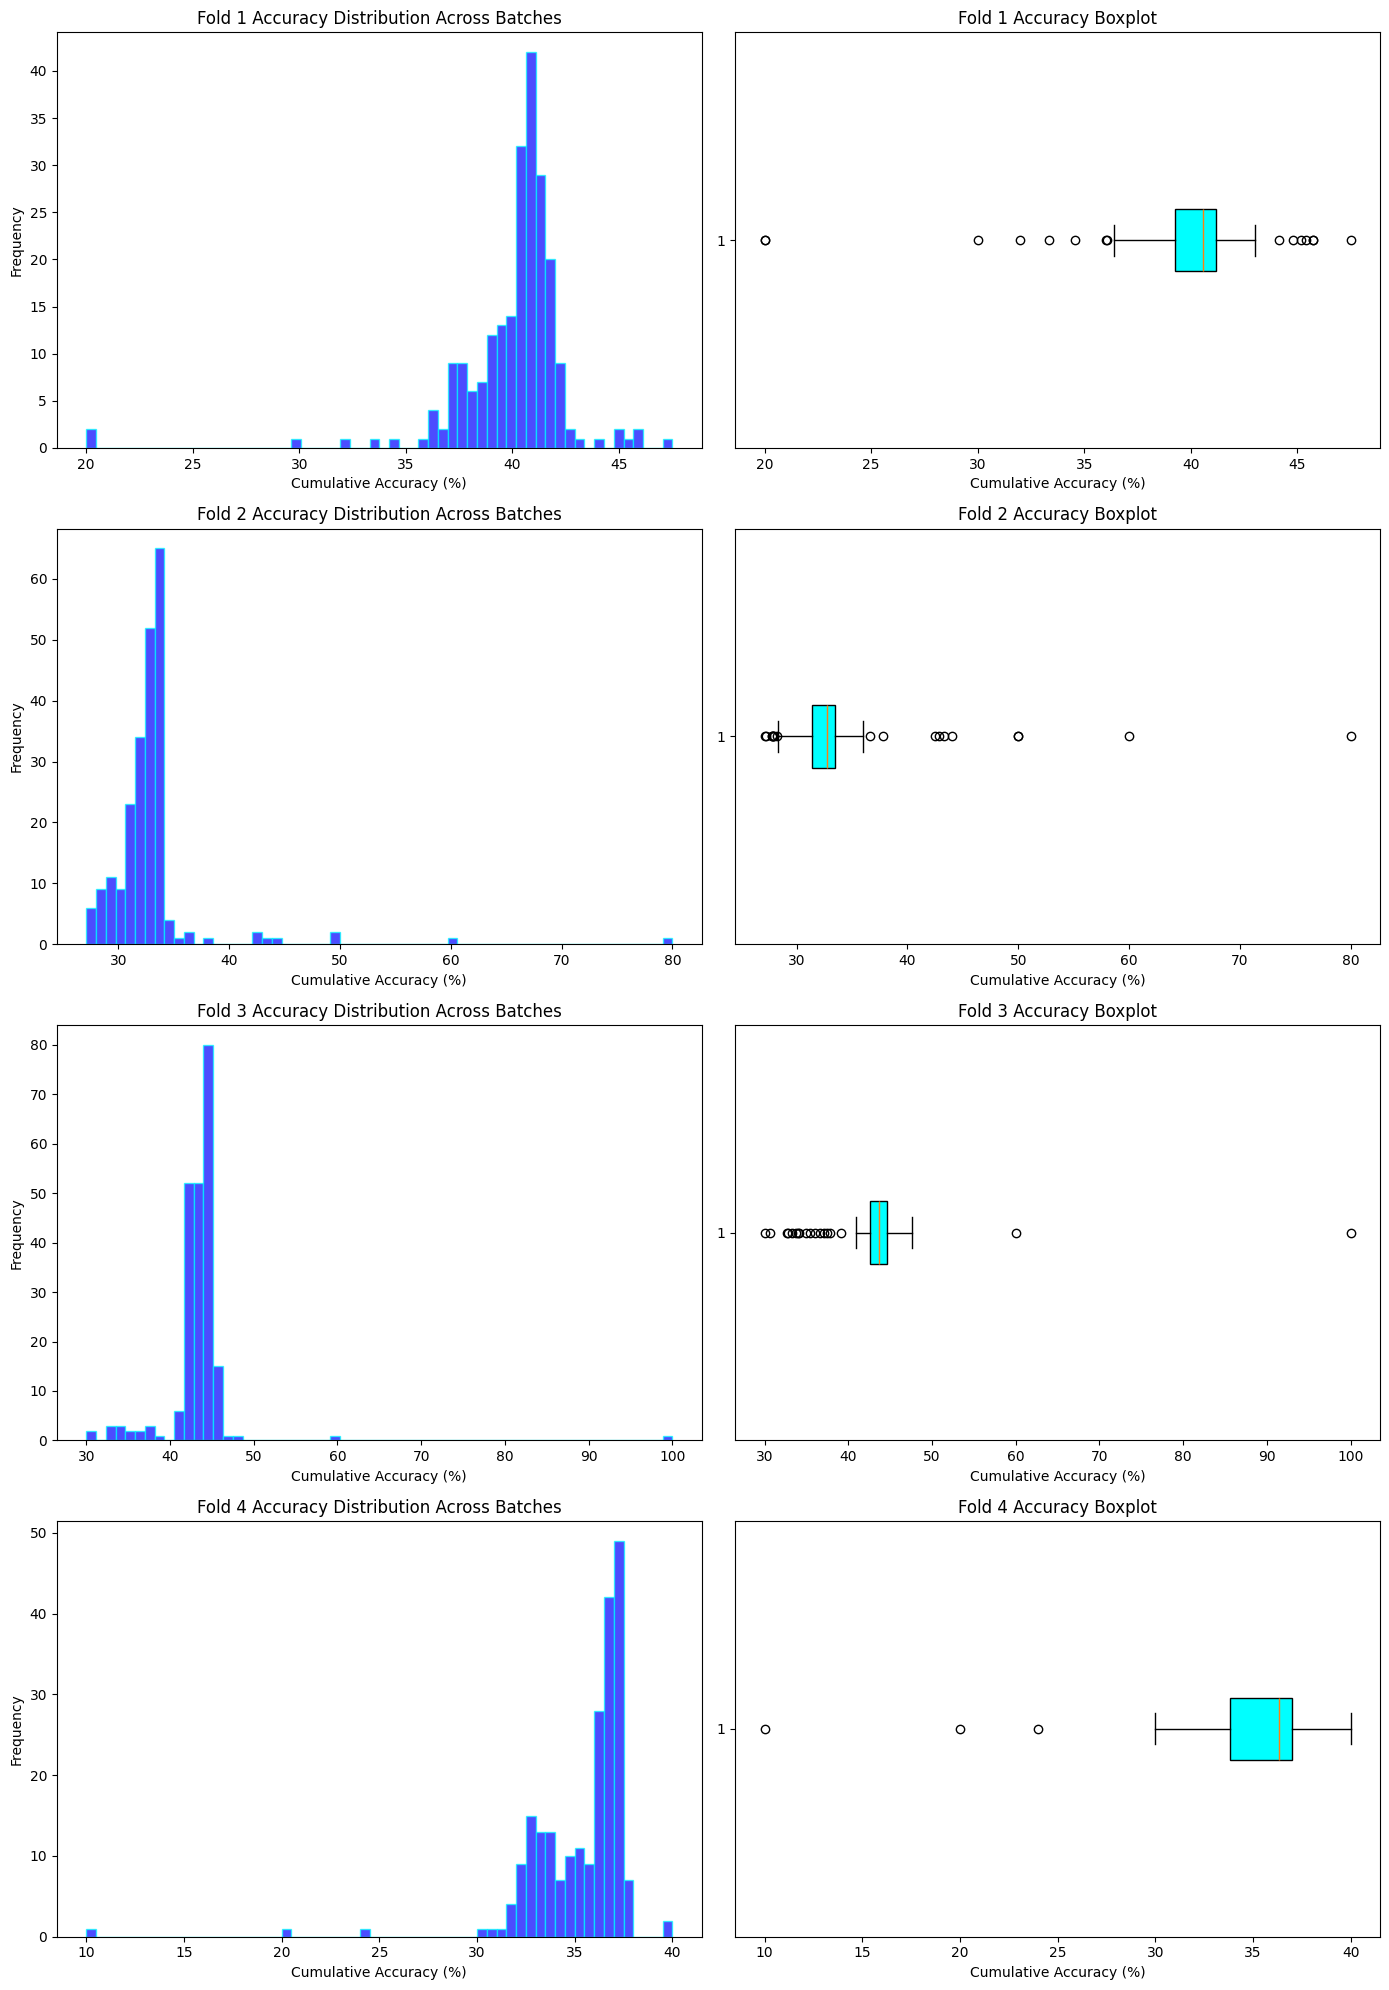

In [7]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader

# Define accuracy threshold (e.g., 5 pixels)
threshold = 5

def clip_to_boundaries(x, y, image_width, image_height):
    x = np.clip(x, 0, image_width - 1)
    y = np.clip(y, 0, image_height - 1)
    return x, y

# Define region names
region_names = ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]

# Initialize tables for metrics
overall_metrics = []
region_accuracy_table = pd.DataFrame(index=region_names)
fold_histograms = []

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate each fold model
for fold_index, model_path in enumerate(final_model_path_list, 1):
    print(f"Evaluating Fold {fold_index}: {model_path}")

    # Load model
    model = InceptionNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Initialize metrics for this fold
    mse_list = []
    mae_list = []
    accuracy_per_region = {region: [] for region in region_names}
    batch_accuracies = []  # Track cumulative batch-level accuracy
    total_correct = 0
    total_points = 0

    # Load test data
    test_data_path = os.path.join(image_dir, 'test_dataset.csv')
    test_data = pd.read_csv(test_data_path)
    test_dataset = SpinalImageDataset(test_data, image_dir, transform=None)
    test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        for images_list, labels_list, filenames, modalities in test_data_loader:
            images_batch = torch.cat(images_list, dim=0)
            labels_batch = torch.cat(labels_list, dim=0)

            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            # Get model predictions
            outputs = model(images_batch)

            # Convert to NumPy for accuracy calculations
            images_np = images_batch.cpu().numpy()
            labels_np = labels_batch.cpu().numpy()
            predicted_coords = outputs.cpu().numpy()

            # Denormalize predictions and labels
            predicted_coords[:, ::2] *= images_np[0].shape[2]
            predicted_coords[:, 1::2] *= images_np[0].shape[1]
            labels_np[:, ::2] *= images_np[0].shape[2]
            labels_np[:, 1::2] *= images_np[0].shape[1]

            # Calculate MSE and MAE for this batch
            mse = mean_squared_error(labels_np.flatten(), predicted_coords.flatten())
            mae = mean_absolute_error(labels_np.flatten(), predicted_coords.flatten())
            mse_list.append(mse)
            mae_list.append(mae)

            # Evaluate accuracy per region
            for i in range(images_batch.size(0)):
                ground_truth_coords = labels_np[i]
                predicted_coords_image = predicted_coords[i]

                for j, region_name in enumerate(region_names):
                    gt_x, gt_y = ground_truth_coords[j * 2], ground_truth_coords[j * 2 + 1]
                    pred_x, pred_y = predicted_coords_image[j * 2], predicted_coords_image[j * 2 + 1]

                    # Clip predictions to image boundaries
                    pred_x, pred_y = clip_to_boundaries(pred_x, pred_y, images_np[0].shape[2], images_np[0].shape[1])

                    # Calculate Euclidean distance
                    distance = np.sqrt((gt_x - pred_x) ** 2 + (gt_y - pred_y) ** 2)

                    # Accuracy based on threshold
                    accuracy = 1 if distance <= threshold else 0
                    accuracy_per_region[region_name].append(accuracy)

                    # Update total counters
                    total_correct += accuracy
                    total_points += 1

            # Batch accuracy using cumulative total_correct and total_points
            batch_accuracy = (total_correct / total_points) * 100
            batch_accuracies.append(batch_accuracy)

    # Overall accuracy for this fold
    overall_accuracy = (total_correct / total_points) * 100
    overall_metrics.append({
        "Fold": fold_index,
        "Overall Accuracy (%)": overall_accuracy,
        "Avg MSE": np.mean(mse_list),
        "Avg MAE": np.mean(mae_list)
    })

    # Per-region accuracy for this fold
    region_accuracies = {region: np.mean(accuracy_per_region[region]) * 100 for region in region_names}
    region_accuracy_table[f"Fold {fold_index}"] = pd.Series(region_accuracies)

    # Store batch accuracies for histogram
    fold_histograms.append(batch_accuracies)

# Create a summary DataFrame for overall metrics
overall_metrics_df = pd.DataFrame(overall_metrics)

# Display results
print("\nOverall Metrics:")
print(overall_metrics_df)

print("\nPer-Region Accuracy Table:")
print(region_accuracy_table)

# Plot histograms and boxplots for each fold in a grid layout
num_folds = len(final_model_path_list)
fig, axes = plt.subplots(num_folds, 2, figsize=(14, 5 * num_folds))

# Adjust the number of bins for finer granularity
num_bins = 60  # Increase this value to make the histogram more detailed

for fold_index, batch_accuracies in enumerate(fold_histograms, 1):
    # Histogram
    axes[fold_index - 1, 0].hist(batch_accuracies, bins=num_bins, alpha=0.7, color='blue', edgecolor='cyan')
    axes[fold_index - 1, 0].set_title(f'Fold {fold_index} Accuracy Distribution Across Batches', fontsize=12)
    axes[fold_index - 1, 0].set_xlabel('Cumulative Accuracy (%)', fontsize=10)
    axes[fold_index - 1, 0].set_ylabel('Frequency', fontsize=10)

    # Boxplot
    axes[fold_index - 1, 1].boxplot(batch_accuracies, vert=False, patch_artist=True,
                                    boxprops=dict(facecolor='cyan', color='black'))
    axes[fold_index - 1, 1].set_title(f'Fold {fold_index} Accuracy Boxplot', fontsize=12)
    axes[fold_index - 1, 1].set_xlabel('Cumulative Accuracy (%)', fontsize=10)

# Improve layout spacing
plt.tight_layout()
plt.show()


### New Histogram Rules

Evaluating Fold 1: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_1_Epoch_60.pth


<ipython-input-9-21b1e0a82814>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating Fold 2: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_2_Epoch_60.pth


<ipython-input-9-21b1e0a82814>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating Fold 3: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_3_Epoch_60.pth


<ipython-input-9-21b1e0a82814>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Evaluating Fold 4: /content/drive/MyDrive/MachineLearning/Machine_Learning_Project2024/Trained_Models/InceptionNet_Model_Fold_4_Epoch_60.pth


<ipython-input-9-21b1e0a82814>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


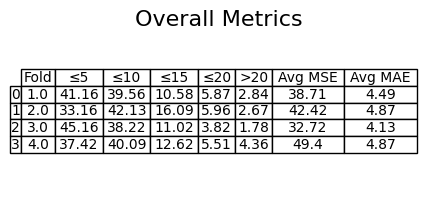

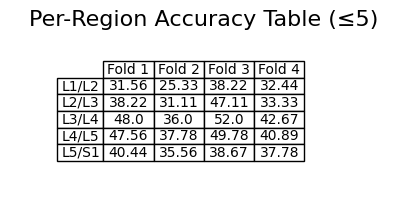

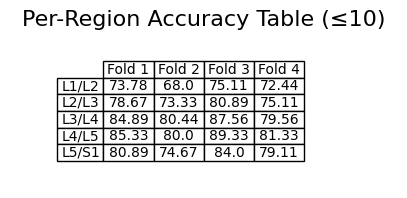

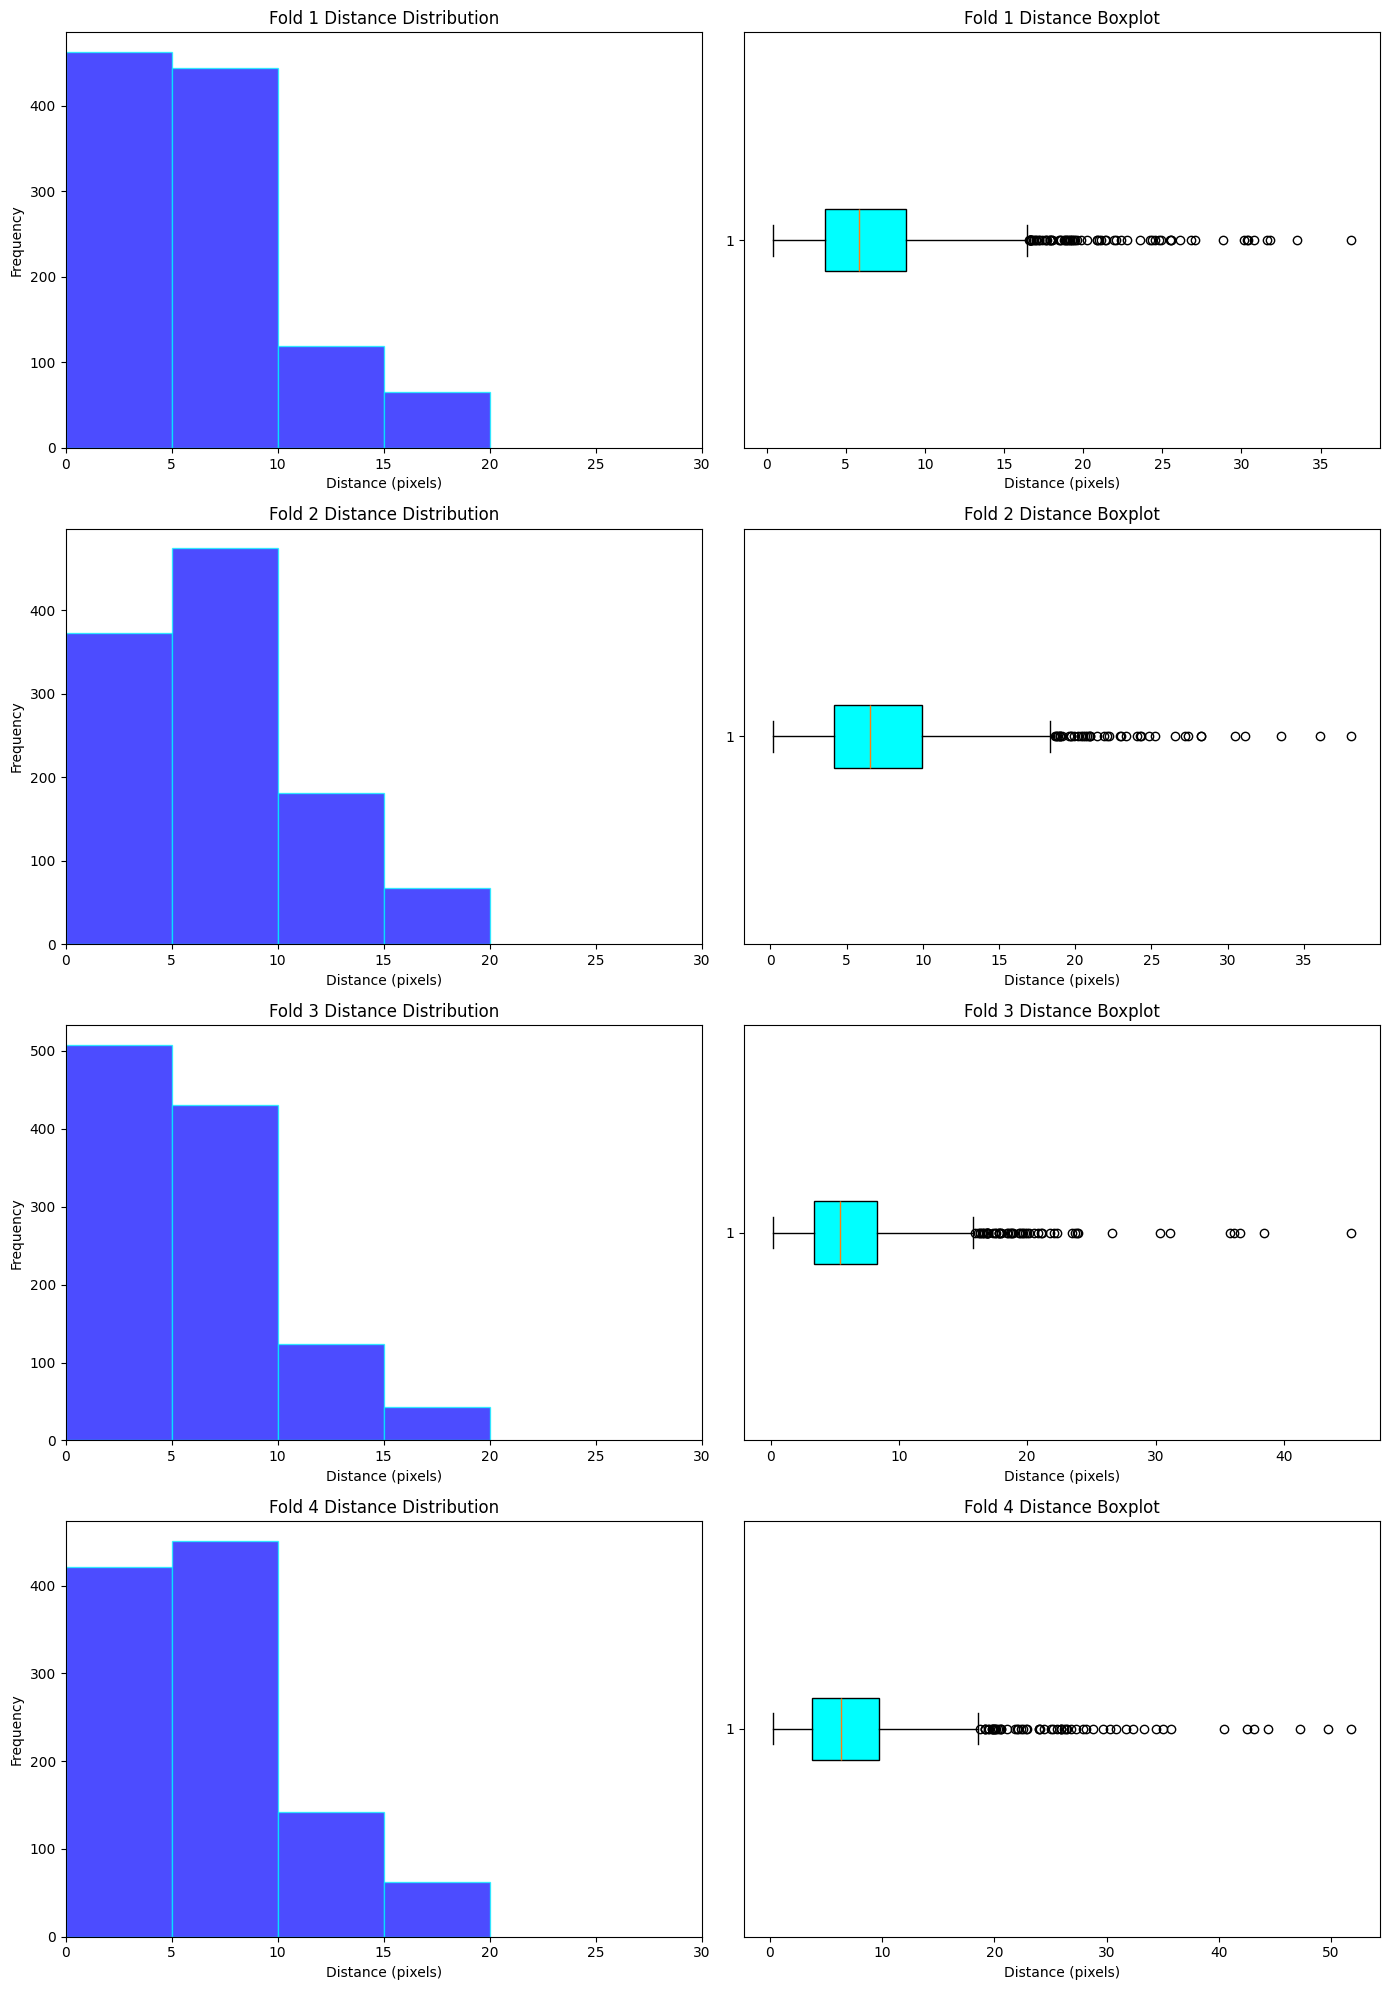

In [9]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader

# Define region names
region_names = ["L1/L2", "L2/L3", "L3/L4", "L4/L5", "L5/S1"]

# Initialize tables for metrics
overall_metrics = []
per_region_accuracy = {region: [] for region in region_names}  # Store accuracy per region per fold
fold_distances = []  # Store distances for histograms and boxplots
bin_ranges = [0, 5, 10, 15, 20, np.inf]  # Bins: ≤5, ≤10, ≤15, ≤20, >20

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate each fold model
for fold_index, model_path in enumerate(final_model_path_list, 1):
    print(f"Evaluating Fold {fold_index}: {model_path}")

    # Load model
    model = InceptionNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Initialize metrics for this fold
    mse_list = []
    mae_list = []
    distances = []  # Track distances for this fold
    accuracy_per_region = {region: {"≤5": 0, "≤10": 0, "total": 0} for region in region_names}
    bin_counts = {f"≤{int(bin_ranges[i])}" if bin_ranges[i] != np.inf else ">20": 0 for i in range(1, len(bin_ranges))}

    # Load test data
    test_data_path = os.path.join(image_dir, 'test_dataset.csv')
    test_data = pd.read_csv(test_data_path)
    test_dataset = SpinalImageDataset(test_data, image_dir, transform=None)
    test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    with torch.no_grad():
        total_points = 0

        for images_list, labels_list, filenames, modalities in test_data_loader:
            images_batch = torch.cat(images_list, dim=0)
            labels_batch = torch.cat(labels_list, dim=0)

            images_batch = images_batch.to(device)
            labels_batch = labels_batch.to(device)

            # Get model predictions
            outputs = model(images_batch)

            # Convert to NumPy
            images_np = images_batch.cpu().numpy()
            labels_np = labels_batch.cpu().numpy()
            predicted_coords = outputs.cpu().numpy()

            # Denormalize predictions and labels
            predicted_coords[:, ::2] *= images_np[0].shape[2]
            predicted_coords[:, 1::2] *= images_np[0].shape[1]
            labels_np[:, ::2] *= images_np[0].shape[2]
            labels_np[:, 1::2] *= images_np[0].shape[1]

            # Calculate distances per point
            for i in range(images_batch.size(0)):
                ground_truth_coords = labels_np[i]
                predicted_coords_image = predicted_coords[i]

                for j, region_name in enumerate(region_names):
                    gt_x, gt_y = ground_truth_coords[j * 2], ground_truth_coords[j * 2 + 1]
                    pred_x, pred_y = predicted_coords_image[j * 2], predicted_coords_image[j * 2 + 1]

                    # Clip predictions to image boundaries
                    pred_x, pred_y = np.clip(pred_x, 0, images_np[0].shape[2] - 1), np.clip(pred_y, 0, images_np[0].shape[1] - 1)

                    # Calculate Euclidean distance
                    distance = np.sqrt((gt_x - pred_x) ** 2 + (gt_y - pred_y) ** 2)
                    distances.append(distance)
                    total_points += 1
                    accuracy_per_region[region_name]["total"] += 1

                    # Update bin counts (overall)
                    for k in range(1, len(bin_ranges)):
                        if distance <= bin_ranges[k]:
                            bin_key = f"≤{int(bin_ranges[k])}" if bin_ranges[k] != np.inf else ">20"
                            bin_counts[bin_key] += 1
                            break

                    # Update per-region accuracy
                    if distance <= 5:
                        accuracy_per_region[region_name]["≤5"] += 1
                    if distance <= 10:
                        accuracy_per_region[region_name]["≤10"] += 1

            # Calculate MSE and MAE for the batch
            mse = mean_squared_error(labels_np.flatten(), predicted_coords.flatten())
            mae = mean_absolute_error(labels_np.flatten(), predicted_coords.flatten())
            mse_list.append(mse)
            mae_list.append(mae)

    # Store distances for this fold
    fold_distances.append(distances)

    # Compute overall metrics for this fold
    overall_bin_percentages = {key: (value / total_points) * 100 for key, value in bin_counts.items()}
    overall_metrics.append({
        "Fold": fold_index,
        **overall_bin_percentages,
        "Avg MSE": float(np.mean(mse_list)) if mse_list else 0.0,
        "Avg MAE": float(np.mean(mae_list)) if mae_list else 0.0,
    })

    # Create summary DataFrame for overall metrics
    overall_metrics_df = pd.DataFrame(overall_metrics)

    # Explicitly round the MSE and MAE columns to 3 decimal places
    if "Avg MSE" in overall_metrics_df.columns:
        overall_metrics_df["Avg MSE"] = overall_metrics_df["Avg MSE"].astype(float).round(3)
    if "Avg MAE" in overall_metrics_df.columns:
        overall_metrics_df["Avg MAE"] = overall_metrics_df["Avg MAE"].astype(float).round(3)

    # Compute per-region percentages and store
    for region, counts in accuracy_per_region.items():
        per_region_accuracy[region].append({
            "≤5": (counts["≤5"] / counts["total"]) * 100,
            "≤10": (counts["≤10"] / counts["total"]) * 100,
        })

# Create summary DataFrame for overall metrics
overall_metrics_df = pd.DataFrame(overall_metrics).round(2)

# Format the Per-Region Accuracy Table for ≤5
region_accuracy_table_cleaned_5 = pd.DataFrame.from_dict({
    region: [fold["≤5"] for fold in per_region_accuracy[region]] for region in region_names
}, orient='index', columns=[f"Fold {i + 1}" for i in range(len(final_model_path_list))]).round(2)

# Format the Per-Region Accuracy Table for ≤10
region_accuracy_table_cleaned_10 = pd.DataFrame.from_dict({
    region: [fold["≤10"] for fold in per_region_accuracy[region]] for region in region_names
}, orient='index', columns=[f"Fold {i + 1}" for i in range(len(final_model_path_list))]).round(2)

# Function to display tables as matplotlib figures
def plot_table(dataframe, title, figsize=(5, 2)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=dataframe.values,
                     colLabels=dataframe.columns,
                     rowLabels=dataframe.index,
                     loc='center',
                     cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))
    plt.title(title, fontsize=16)
    plt.show()

# Display Overall Metrics Table
plot_table(overall_metrics_df, "Overall Metrics")

# Display Per-Region Accuracy Table (≤5)
plot_table(region_accuracy_table_cleaned_5, "Per-Region Accuracy Table (≤5)")

# Display Per-Region Accuracy Table (≤10)
plot_table(region_accuracy_table_cleaned_10, "Per-Region Accuracy Table (≤10)")

# Plot histograms and boxplots for distances in each fold
num_folds = len(final_model_path_list)
fig, axes = plt.subplots(num_folds, 2, figsize=(14, 5 * num_folds))

for fold_index, distances in enumerate(fold_distances, 1):
    # Histogram
    axes[fold_index - 1, 0].hist(distances, bins=bin_ranges[:-1], alpha=0.7, color='blue', edgecolor='cyan')
    axes[fold_index - 1, 0].set_title(f'Fold {fold_index} Distance Distribution', fontsize=12)
    axes[fold_index - 1, 0].set_xlabel('Distance (pixels)', fontsize=10)
    axes[fold_index - 1, 0].set_ylabel('Frequency', fontsize=10)
    axes[fold_index - 1, 0].set_xlim(0, 30)  # Limit x-axis to 30 pixels
    axes[fold_index - 1, 0].set_xticks(range(0, 35, 5))  # Increment ticks by 5

    # Boxplot
    axes[fold_index - 1, 1].boxplot(distances, vert=False, patch_artist=True, boxprops=dict(facecolor='cyan', color='black'))
    axes[fold_index - 1, 1].set_title(f'Fold {fold_index} Distance Boxplot', fontsize=12)
    axes[fold_index - 1, 1].set_xlabel('Distance (pixels)', fontsize=10)

# Improve layout spacing
plt.tight_layout()
plt.show()
